In [1]:
import numpy as np
from numba import njit
from numba_stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import json

from nested_mc import NestedMonteCarlo, gaussian_cdf, uniform_importance_sampling

### Introduction

The goal of our project was to study and implement 5 nested Monte Carlo methods proposed in the article

> M. Broadie, Y. Du, and C. C. Moallemi, “Efficient risk estimation via nested sequential simulation,” Manage. Sci., vol. 57, no. 6, pp. 1172–1194, 2011.

The problem we are facing is the estimation of the loss probability
$$
\alpha = \mathbb{P}(L \geq c)
$$
for a given threshold $c \in \mathbb{R}$. Here, the loss $L$ is a random variable that depends on the realized scenario $\omega \in \Omega$. Hence, two levels appear in the Monte Carlo simulation:
1. **Outer level**: simulate the scenarios $\omega_1, \ldots, \omega_n$.
2. **Inner level**: for each scenario $\omega_i$ simulate the loss values $Z_{i, 1}, \ldots, Z_{i, m_i}$ and approximate $\hat L(\omega_i) = \dfrac{1}{m_i}\sum_{j=1}^{m_i}Z_{i,j}.$
3. Estimate the probability of the loss $L$ exceeding $c$ by
$$
\hat \alpha = \dfrac1n\sum_{i=1}^n \mathbb{I}_{\hat L(\omega_i) \geq c}.
$$

Several question arises:
- Given a computation budget $k$, how to choose optimally the values of $n$ and $m_i, \ i = 1, \ldots,  n$ to minimize the MSE of the estimator $\hat\alpha$?

The following methods were proposed by the authors and implemented within this project:
1. **Uniform sampling 1/3:2/3** (Algorithm 1 in the article): in this case $m_i = m$ does not depend on $i$, and we have $k = mn$. It was shown by authors that the optimal allocation is attained for $n \propto k^{2/3}$ and $m \propto k^{1/3}$. In this case, the optimal MSE decays as $k^{-2/3}$ which is slower than for standard Monte Carlo. Moreover, the proportionality constant is very difficult to calculate for real-world problems, so one takes simply $n = k^{2/3}$ and $m = k^{1/3}$.
2. **Optimal uniform sampling** (still Algorithm 1 in the article): For the considered example, the proportionality constant $\beta$ mentioned in the description of the first method can be calculated explicitly and we take $n = \beta k^{2/3}$ and $m = \dfrac{1}{\beta}k^{1/3}$. We will see that the role of this constant is crucial for the algorithm's performance.
3. **Sequential sampling** (Algorithm 2 in the article): The idea of the sequential algorithm is to generate more inner losses for scenarios $\omega$ such that $L(\omega)$ is close to $c$ hence the accurate estimation of this value may change the final estimator involving $\mathbb{I}_{\hat L(\omega_i) \geq c}$. Thus, at each step on chooses a scenario $\omega_{i^*}$ such that the probability of change of $\mathbb{I}_{\hat L(\omega_i) \geq c}$ is the highest. This is achived by taking the scenario with the smallest value of $\dfrac{m_i}{\sigma_i}|\hat L_i - c|$, where $\sigma_i$ is the volatility of the inner loss given the scenario $\omega_i$ (assumed to be known). The parameters of the algorithm are $m^0$ - minimal value of $m_i$, $\bar m$ - average value of $m_i$ such that $k = n\bar m$, $n$ - number of outer scenarios simulations. For the value of $n$, we took the value obtained by the authors by minimization of the method's MSE. Thus, sequential method will serve as a benchmark other methods to be compared with.
4. **Threshold-based method** (Algorithm 3 in the article): This algorithm simulates the inner losses for $n$ outer scenarios one-by-one until the certain value $\gamma$ of $\dfrac{m_i}{\sigma_i}|\hat L_i - c|$ is attained for each simulated scenario $\omega_i$. This algorithm is not compared with others as it does not allow to control the computation budget $k$.
5. **Adaptive algorithm** (Algorithm 4 in the article): Neither sequential nor threshold-based method do not propose the way to choose $n$. This problem is addressed by the adaptive algorithm that starts with simulation of $n^0$ scenarios and increases this number according to the solution of an optimization problem at the beginning of each epoch of size $\tau_e$. During each epoch, at least $m^0$ inner losses for each simulated scenario should be generated. Once it is done, the sequential algorithm is applied to already simulated scenarios until the number of inner losses simulations attains $\tau_e$.
6. **Adaptive algorithm with volatility estimation** (still Algorithm 4 in the article): In all the algorithms we considered, $\sigma_i$ were supposed to be known explicitly, which is not always true in practice. In this algorithm, we estimate the volatility from the sample for simulated inner losses and use $\hat\sigma_i$ instead of exact value $\sigma_i$ for each scenario.

## Gaussian example

We will illustrate the implementation of the algorithms on two examples considered in the article. In the first example, we have
$$
\omega \sim \mathcal{N}(0, 1)
$$
and
$$
Z_{i, j}= -\omega_i + W_{i, j}, \quad W_{i, j} \sim \mathcal{N}(0, \sigma_{\mathrm{outer}}^2)
$$
with $ \sigma_{\mathrm{outer}} = 5$. We take the threshold level $c \approx 2.326347$ that corresponds to $\alpha = 0.01$.

In [2]:
sigma_inner = 5

@njit
def gaussian_simulate_scenario(size):
    return np.random.randn(size)

@njit
def gaussian_simulate_scenario_is(size, mean_is_gauss=-2.4):
    W = mean_is_gauss + np.random.randn(size)
    return W,  np.exp(0.5 * mean_is_gauss**2 - mean_is_gauss * W)

@njit
def gaussian_simulate_inner_loss(scenario, size):
    return -scenario + np.random.randn(size) * np.sqrt(sigma_inner)

@njit
def gaussian_inner_std(scenarios):
    return np.ones_like(scenarios) * sigma_inner

threshold_gauss = 2.3263478740408408 # corresponds to loss of 1%
norm.cdf(-threshold_gauss, loc=0, scale=1)

array(0.01)

In [3]:
nested_mc_gauss = NestedMonteCarlo(
    simulate_scenario=gaussian_simulate_scenario,
    simulate_inner_loss=gaussian_simulate_inner_loss,
    loss_threshold=threshold_gauss,
    inner_loss_std=gaussian_inner_std,
)

### Sanity check for all algorithms

Optimal values of $n$ and $m$ corresponding to the budget $k = 4 \cdot 10^6$.

In [4]:
n_opt = 4499
m_opt = 889

beta_gauss = n_opt / (n_opt * m_opt)**(2/3) 
beta_gauss

0.17855450979181522

In [8]:
# optimal uniform
nested_mc_gauss.estimation_uniform(m=m_opt, n=n_opt)

(0.008890864636585907, (0.00614757852913709, 0.011634150744034726))

In [9]:
# 1/3:2/3 uniform
nested_mc_gauss.estimation_uniform(m=159, n=25199)

(0.011389340846859003, (0.010079172826335551, 0.012699508867382454))

In [10]:
# sequential
nested_mc_gauss.estimation_sequential(m_init=2, m_average=130, n=30860)

(0.010110174983797796, (0.008994006043921036, 0.011226343923674557))

In [11]:
# threshold
nested_mc_gauss.estimation_threshold(error_margin=2, n=n_opt)

(0.016670371193598578, (0.012928743570536076, 0.02041199881666108))

In [12]:
# adaptative algorithm
nested_mc_gauss.estimation_adaptive(n_0=500, m_0=2, tau_e=100_000, k=n_opt * m_opt)

(0.00946969696969697, (0.007574397243430467, 0.011364996695963473))

In [11]:
# adaptative algorithm with vol estimation
nested_mc_gauss.estimation_adaptive(n_0=500, m_0=50, tau_e=50000, k=n_opt * m_opt, estimate_inner_std=True)

(0.013121904571288492, (0.013005437019713864, 0.01323837212286312))

## Put option example

In this example, we consider a portfolio consisting of a put option sold at $t = 0$ at a price $X_0$. We are interested in the loss at time $t = \tau$, namely
$$
L(\omega) = X_0 - \mathbb{E}[e^{-r(T-\tau)}(K - S_T(\omega, W))^+],
$$
where
$$
S_T(\omega, W) := S_\tau(\omega)e^{(r-\sigma^2/2)(T-\tau) + \sigma\sqrt{T-\tau}W}, \quad W \sim\mathcal{N}(0, 1),
$$
and the scenario describes the underlying price at $t =\tau$ simulated under the historical probability:
$$
S_\tau(\omega) := S_0e^{(\mu-\sigma^2/2)\tau + \sigma\sqrt{\tau}\omega}, \quad \omega \sim\mathcal{N}(0, 1).
$$
Hence, the inner loss sample takes the form
$$
Z_{i, j} = X_0 - e^{-r(T-\tau)}(K - S_T(\omega_i, W_{i, j}))^+.
$$
For this example, the computation of $\sigma(\omega_i)$ is reduced to the calculation of the second moment of $e^{-r(T-\tau)}(K - S_T(\omega_i, W_{i, j}))^+$ which was found to be equal to
$$
e^{-2r(T-\tau)}K^2\Phi(-d_-) - 2e^{-r(T-\tau)}KS_\tau\Phi(-d_+) + e^{\sigma^2(T-\tau)}S_0^2\Phi(-d_- - 2\sigma\sqrt{T-\tau}),
$$
where $d_-$ and $d_+$ are given by standard Black-Scholes formula.

In [5]:
S0 = 100
K = 95
T = 0.25
tau = 1 / 52
sigma = 0.2
mu = 0.08
r = 0.03
X0 = 1.669 # by BS qformula
threshold_put = 1.221 # corresponds to loss of 1%

@njit
def put_simulate_scenario(size):
    return S0 * np.exp(
        (mu - 0.5 * sigma**2) * tau + 
         sigma * np.sqrt(tau) * np.random.randn(size)
    )

@njit
def put_simulate_scenario_is(size, mean_is_put=2.2):
    W = (np.random.randn(size) + mean_is_put)
    return S0 * np.exp(
        (mu - 0.5 * sigma**2) * tau + 
         sigma * np.sqrt(tau) * W
    ),  np.exp(0.5 * mean_is_put**2 - mean_is_put * W)

@njit
def put_simulate_inner_loss(size, scenario):
    S_T = scenario * np.exp(
        (r - 0.5 * sigma**2) * (T - tau) + 
         sigma * np.sqrt(T - tau) * np.random.randn(size)
    )
    return X0 - np.exp(-r * (T - tau)) * np.maximum(0, K - S_T)

@njit
def bs_put(scenario):
    """
    Calculates the value of the put option with expiration T and strike K at t = tau given the scenario S_tau.
    """
    S_tau = scenario
    d1 = (np.log(S_tau / K) + (r + 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    d2 = (np.log(S_tau / K) + (r - 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    return K * np.exp(-r * (T - tau)) * gaussian_cdf(-d2) - S_tau * gaussian_cdf(-d1)

@njit
def bs_inner_vol(scenario):
    """
    Calculates standard deviation for a given scenario S_tau.
    """
    S_tau = scenario
    d1 = (np.log(S_tau / K) + (r + 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    d2 = (np.log(S_tau / K) + (r - 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    second_moment = np.exp(-2 * r * (T - tau)) * K**2 * gaussian_cdf(-d2) - 2 * K * S_tau * np.exp(-r * (T - tau)) * gaussian_cdf(-d1) + \
        S_tau**2 * np.exp(sigma**2 * (T - tau)) * gaussian_cdf(-d2 - 2 * sigma * np.sqrt(T - tau))
    return np.sqrt(second_moment - bs_put(scenario)**2)

@njit
def bs_inner_vol_vect(scenarios):
    return np.array(list(map(bs_inner_vol, scenarios)))

In [6]:
nested_mc_put = NestedMonteCarlo(
    simulate_scenario=put_simulate_scenario,
    simulate_inner_loss=put_simulate_inner_loss,
    loss_threshold=threshold_put,
    inner_loss_std=bs_inner_vol_vect
)

### Sanity check for all algorithms

In [7]:
n_opt = 3143
m_opt = 1273
beta_put = n_opt / (n_opt * m_opt)**(2/3) 
beta_put

0.12470844324776952

In [54]:
# optimal uniform
nested_mc_put.estimation_uniform(m=m_opt, n=n_opt)

(0.012726694241170856, (0.008807276960364662, 0.01664611152197705))

In [55]:
# 1/3:2/3 uniform
nested_mc_put.estimation_uniform(m=159, n=25199)

(0.019048374935513313, (0.01736058724111355, 0.020736162629913076))

In [56]:
# sequential
nested_mc_put.estimation_sequential(m_init=2, n=19558, m_average=205)

(0.009970344616013907, (0.00857790567668186, 0.011362783555345955))

In [57]:
# threshold
nested_mc_put.estimation_threshold(error_margin=50, n=n_opt)

(0.009863188036907413, (0.006407764710290968, 0.013318611363523858))

In [58]:
# adaptative algorithm
nested_mc_put.estimation_adaptive(n_0=500, m_0=2, tau_e=10_000, k=n_opt * m_opt)

(0.009709887507400828, (0.007618366170817439, 0.011801408843984219))

In [9]:
# adaptative algorithm with vol estimation
nested_mc_put.estimation_adaptive(n_0=500, m_0=50, tau_e=50_000, k=n_opt * m_opt, estimate_inner_std=True)

(0.019448946515397084, (0.008543564556669188, 0.030354328474124982))

### Number of inner stage samples 

Here we illustrates the allocation of the inner losses sample sizes for the sequential method as a function of $L(\omega)$ for both examples we consider.

The obtained results correspond well to the plots provided in the article.

In [21]:
nested_mc_gauss.return_ci = False
nested_mc_put.return_ci = False
_, inner_losses_mean_gauss, m_array_gauss = nested_mc_gauss.estimation_sequential(m_init=10, m_average=m_opt, n=n_opt, return_info=True)
_, inner_losses_mean_put, m_array_put = nested_mc_put.estimation_sequential(m_init=10, m_average=m_opt, n=n_opt, return_info=True)

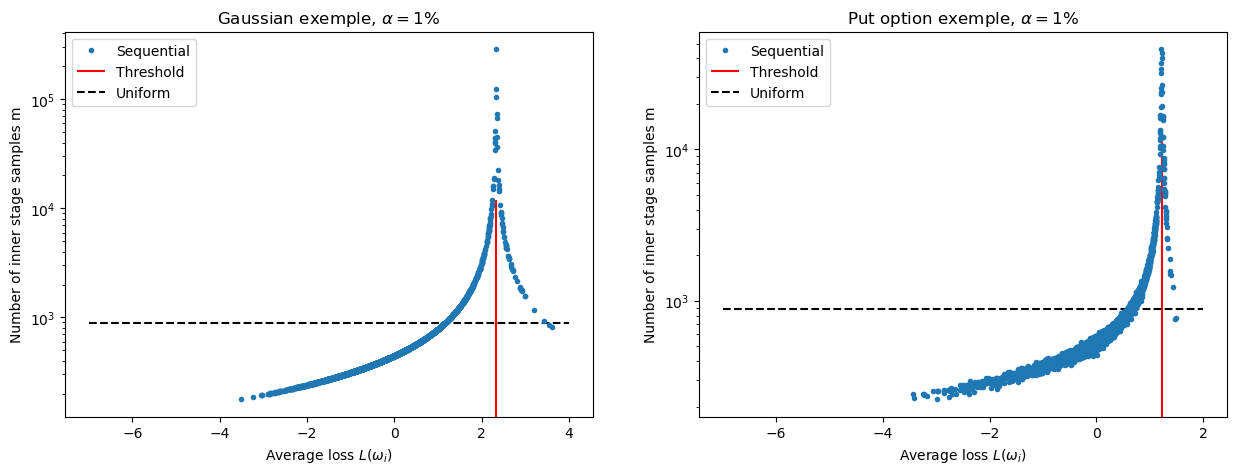

In [28]:
fix, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(inner_losses_mean_gauss, m_array_gauss, '.', label='Sequential')
ax[0].vlines(x=threshold_gauss, ymin=0, ymax=12000, color='r', label='Threshold')
ax[0].hlines(m_opt, -7, 4, color='k', ls='--', label='Uniform')
ax[0].legend()
ax[0].set_title(r'Gaussian exemple, $\alpha = 1\%$')
ax[0].set_xlabel('Average loss $L(\omega_i)$')
ax[0].set_ylabel('Number of inner stage samples m')
ax[0].set_yscale('log')

ax[1].plot(inner_losses_mean_put, m_array_put, '.', label='Sequential')
ax[1].vlines(x=threshold_put, ymin=0, ymax=12000, color='r', label='Threshold')
ax[1].hlines(m_opt, -7, 2, color='k', ls='--', label='Uniform')
ax[1].legend()
ax[1].set_title(r'Put option exemple, $\alpha = 1\%$')
ax[1].set_xlabel('Average loss $L(\omega_i)$')
ax[1].set_ylabel('Number of inner stage samples m')
ax[1].set_yscale('log')

### Variance reduction

#### Gaussian example

Optimisation of the parameter $\theta$

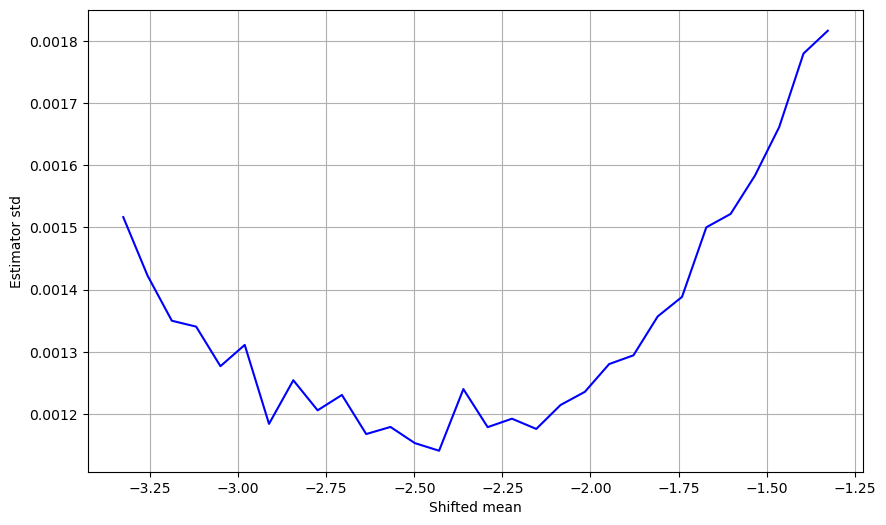

In [18]:
nested_mc_gauss.return_ci = True
nested_mc_put.return_ci = True

m_is_arr = np.linspace(-1, 1, 30) -threshold_gauss
budget = 20_000_000
n_opts = int((budget)**(1/3) / beta_put)
m_opts = int((budget)**(2/3) * beta_put)
results = [uniform_importance_sampling(m=m_opt, n=n_opt, simulate_scenario=lambda size: gaussian_simulate_scenario_is(size, m_is), 
                                       simulate_inner_loss=gaussian_simulate_inner_loss, loss_threshold=threshold_gauss) for m_is in m_is_arr]

variances = [res[1][1] - res[1][0] for res in results]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(m_is_arr, variances, 'b')
ax.set_xlabel('Shifted mean')
ax.set_ylabel('Estimator std')
ax.grid()

Comparison of variances for the uniform algorithm

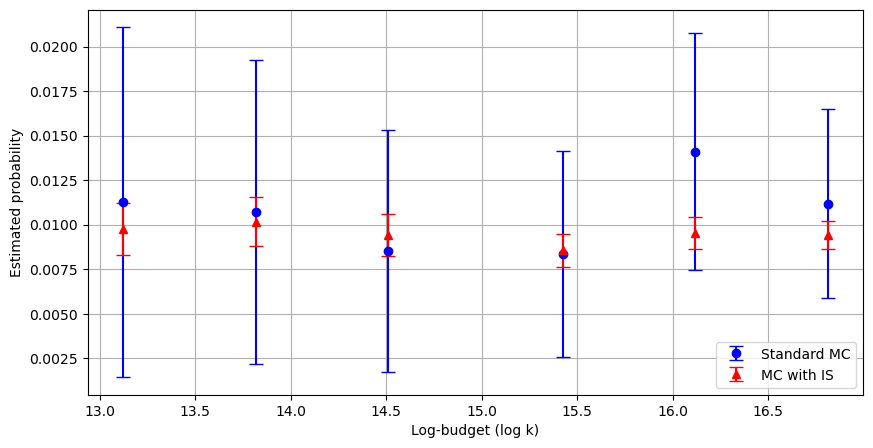

In [20]:
budget = np.array([500_000, 1_000_000, 2_000_000, 5_000_000, 10_000_000, 20_000_000])
n_opts = ((budget)**(1/3) / beta_gauss).astype(int)
m_opts = ((budget)**(2/3) * beta_gauss).astype(int)

results = [nested_mc_gauss.estimation_uniform(m, n) for m, n in zip(m_opts, n_opts)]
results_var_red = [uniform_importance_sampling(m=m, n=n, simulate_scenario=gaussian_simulate_scenario_is, simulate_inner_loss=gaussian_simulate_inner_loss,
                                               loss_threshold=threshold_gauss) for m, n in zip(m_opts, n_opts)]

means = [result[0] for result in results]
ci_lowers = [result[1][0] for result in results]
ci_uppers = [result[1][1] for result in results]
errors = [np.abs(np.array(means) - np.array(ci_lowers)), np.abs(np.array(ci_uppers) - np.array(means))]

means_var_red = [result[0] for result in results_var_red]
ci_lowers_var_red = [result[1][0] for result in results_var_red]
ci_uppers_var_red = [result[1][1] for result in results_var_red]
errors_var_red = [np.abs(np.array(means_var_red) - np.array(ci_lowers_var_red)), np.abs(np.array(ci_uppers_var_red) - np.array(means_var_red))]


plt.figure(figsize=(10, 5))
plt.errorbar(np.log(budget), means, yerr=errors, fmt='o', capsize=5, color='blue', label='Standard MC')
plt.errorbar(np.log(budget), means_var_red, yerr=errors_var_red, fmt='^', capsize=5, color='red', label='MC with IS')
plt.xlabel('Log-budget (log k)')
plt.ylabel('Estimated probability')
# plt.title('Effect of Antithetic Variable on Put Option Valuation')
plt.legend()
plt.grid(True)
plt.show()

#### Put option

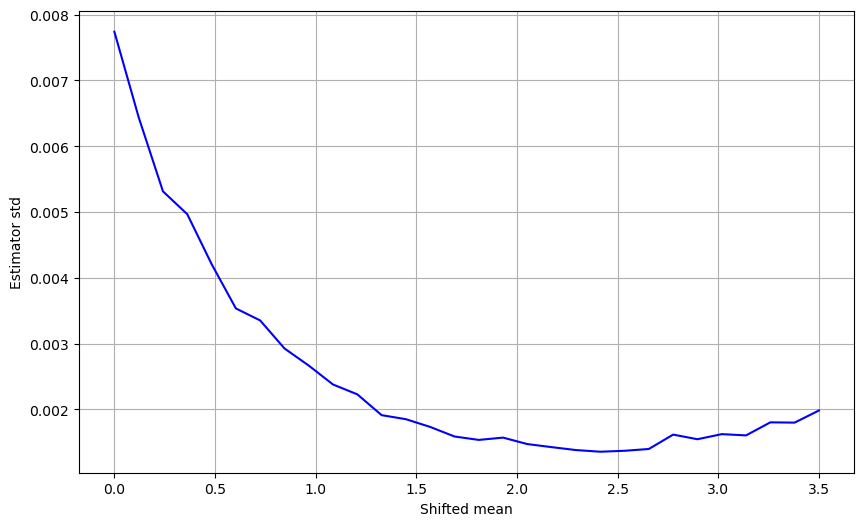

In [21]:
m_arr = np.linspace(0., 3.5, 30)
budget = 20_000_000
n_opts = int((budget)**(1/3) / beta_put)
m_opts = int((budget)**(2/3) * beta_put)
results = [uniform_importance_sampling(m=m_opt, n=n_opt, simulate_scenario=lambda size: put_simulate_scenario_is(size, m), simulate_inner_loss=put_simulate_inner_loss,
                                       loss_threshold=threshold_put, return_ci=True) for m in m_arr]

variances = [res[1][1] - res[1][0] for res in results]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(m_arr, variances, 'b')
ax.set_xlabel('Shifted mean')
ax.set_ylabel('Estimator std')
ax.grid()

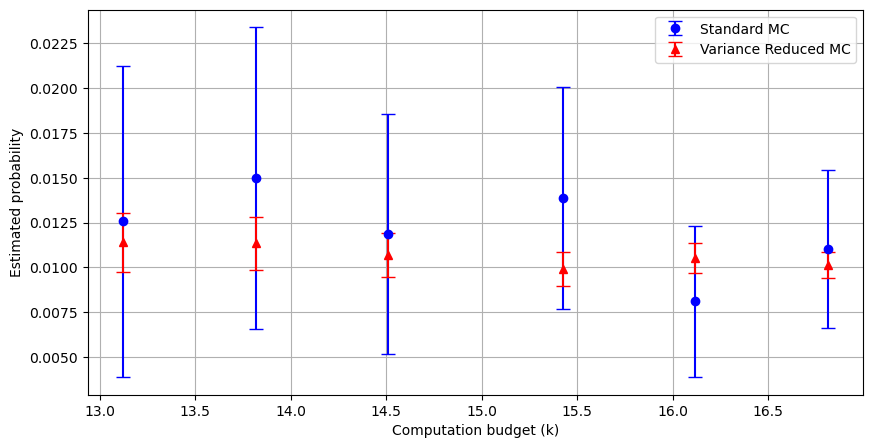

In [25]:
budget = np.array([500_000, 1_000_000, 2_000_000, 5_000_000, 10_000_000, 20_000_000])
n_opts = ((budget)**(1/3) / beta_put).astype(int)
m_opts = ((budget)**(2/3) * beta_put).astype(int)

results = [nested_mc_put.estimation_uniform(m, n) for m, n in zip(m_opts, n_opts)]
results_var_red = [uniform_importance_sampling(m=m, n=n, simulate_scenario=put_simulate_scenario_is, simulate_inner_loss=put_simulate_inner_loss,
                                               loss_threshold=threshold_put) for m, n in zip(m_opts, n_opts)]

means = [result[0] for result in results]
ci_lowers = [result[1][0] for result in results]
ci_uppers = [result[1][1] for result in results]
errors = [np.abs(np.array(means) - np.array(ci_lowers)), np.abs(np.array(ci_uppers) - np.array(means))]

means_var_red = [result[0] for result in results_var_red]
ci_lowers_var_red = [result[1][0] for result in results_var_red]
ci_uppers_var_red = [result[1][1] for result in results_var_red]
errors_var_red = [np.abs(np.array(means_var_red) - np.array(ci_lowers_var_red)), np.abs(np.array(ci_uppers_var_red) - np.array(means_var_red))]


plt.figure(figsize=(10, 5))
plt.errorbar(np.log(budget), means, yerr=errors, fmt='o', capsize=5, color='blue', label='Standard MC')
plt.errorbar(np.log(budget), means_var_red, yerr=errors_var_red, fmt='^', capsize=5, color='red', label='Variance Reduced MC')
plt.xlabel('Computation budget (k)')
plt.ylabel('Estimated probability')
# plt.title('Effect of Antithetic Variable on Put Option Valuation')
plt.legend()
plt.grid(True)
plt.show()

We note that importance sampling performs very well and allows for significant variance reduction in both cases.

### Calculating statistics for each method

As the running of each algorithm takes a lot of time, we needed several iterations to collect the data. Note also, that due to the extremely low speed of the sequential algorithm with the optimal parameters, we have less samples for it and the adaptive algorithm.  

In [30]:
nested_mc_gauss.return_ci = False
nested_mc_put.return_ci = False

problems = ['gaussian', 'put']
methods_names = ['uniform_optimal', 'uniform_1/3:2/3', 'uniform_optimal_is', 'uniform_1/3:2/3_is', 'adaptative', 'adaptative+vol_estim', 'optimal_sequential']
number_of_iters = {
    'gaussian_uniform_optimal': 0,
    'gaussian_uniform_1/3:2/3': 0,
    'gaussian_uniform_optimal_is': 1000,
    'gaussian_uniform_1/3:2/3_is': 1000,    
    'gaussian_adaptative': 0,
    'gaussian_adaptative+vol_estim': 0,
    'gaussian_optimal_sequential': 0,
    'put_uniform_optimal': 0,
    'put_uniform_1/3:2/3': 0,
    'put_uniform_optimal_is': 1000,
    'put_uniform_1/3:2/3_is': 1000,
    'put_adaptative': 0,
    'put_adaptative+vol_estim': 0,
    'put_optimal_sequential': 0
}

methods = {
    'gaussian_uniform_optimal': lambda: nested_mc_gauss.estimation_uniform(n=5089, m=786),
    'gaussian_uniform_1/3:2/3': lambda: nested_mc_gauss.estimation_uniform(n=25199, m=159),
    'gaussian_uniform_optimal_is': lambda: uniform_importance_sampling(m=786, n=5089, simulate_scenario=gaussian_simulate_scenario_is, simulate_inner_loss=gaussian_simulate_inner_loss,
                                               loss_threshold=threshold_gauss),
    'gaussian_uniform_1/3:2/3_is': lambda: uniform_importance_sampling(m=159, n=25199, simulate_scenario=gaussian_simulate_scenario_is, simulate_inner_loss=gaussian_simulate_inner_loss,
                                               loss_threshold=threshold_gauss),    
    'gaussian_adaptative': lambda: nested_mc_gauss.estimation_adaptive(n_0=500, m_0=2, tau_e=10_000, k=4_000_000),
    'gaussian_adaptative+vol_estim': lambda: nested_mc_gauss.estimation_adaptive(n_0=500, m_0=2, tau_e=10_000, k=4_000_000, estimate_inner_std=True),
    'gaussian_optimal_sequential': lambda: nested_mc_gauss.estimation_sequential(m_init=2, n=30860, m_average=130),
    'put_uniform_optimal': lambda: nested_mc_put.estimation_uniform(n=3143, m=1273),
    'put_uniform_1/3:2/3': lambda: nested_mc_put.estimation_uniform(n=25199, m=159),
    'put_uniform_optimal_is': lambda: uniform_importance_sampling(m=1273, n=3143, simulate_scenario=put_simulate_scenario_is, simulate_inner_loss=put_simulate_inner_loss,
                                               loss_threshold=threshold_put),
    'put_uniform_1/3:2/3_is': lambda: uniform_importance_sampling(m=159, n=25199, simulate_scenario=put_simulate_scenario_is, simulate_inner_loss=put_simulate_inner_loss,
                                               loss_threshold=threshold_put),
    'put_adaptative': lambda: nested_mc_put.estimation_adaptive(n_0=500, m_0=2, tau_e=10_000, k=4_000_000),
    'put_adaptative+vol_estim': lambda: nested_mc_put.estimation_adaptive(n_0=500, m_0=2, tau_e=10_000, k=4_000_000, estimate_inner_std=True),
    'put_optimal_sequential': lambda: nested_mc_put.estimation_sequential(m_init=2, n=19558, m_average=205)
}

with open('stats.json') as json_file:
    stats = json.load(json_file)

In [31]:
for method_name in methods_names:
    for problem in problems:
        print(problem, method_name)
        if method_name not in stats[problem]:
            stats[problem][method_name] = []
        for _ in tqdm(range(number_of_iters[problem + '_' + method_name])):
            method = methods[problem + '_' + method_name]
            stats[problem][method_name].append(method())

        with open("stats.json", "w") as outfile: 
            json.dump(stats, outfile)

gaussian uniform_optimal


0it [00:00, ?it/s]


put uniform_optimal


0it [00:00, ?it/s]


gaussian uniform_1/3:2/3


0it [00:00, ?it/s]


put uniform_1/3:2/3


0it [00:00, ?it/s]


gaussian uniform_optimal_is


100%|██████████| 1000/1000 [03:00<00:00,  5.54it/s]


put uniform_optimal_is


100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


gaussian uniform_1/3:2/3_is


100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


put uniform_1/3:2/3_is


100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]


gaussian adaptative


0it [00:00, ?it/s]


put adaptative


0it [00:00, ?it/s]


gaussian adaptative+vol_estim


0it [00:00, ?it/s]


put adaptative+vol_estim


0it [00:00, ?it/s]


gaussian optimal_sequential


0it [00:00, ?it/s]


put optimal_sequential


0it [00:00, ?it/s]


### Stats analysis

In this section, we compare the statistics such as variance, bias and MSE for each of the implemented methods.

In [32]:
with open('stats.json') as json_file:
    stats = json.load(json_file)

In [33]:
true_alpha = 0.01

def bias_squared(alphas):
    return (np.mean(alphas) - true_alpha)**2

def mse(alphas):
    return np.mean((np.array(alphas) - true_alpha)**2)

def variance(alphas):
    return np.var(alphas)

In [44]:
results_dfs = {}

for problem in problems:
    data = []
    for method_name in methods_names:
        alphas = stats[problem][method_name]
        data.append([func(alphas) for func in [bias_squared, variance, mse]])

    results_dfs[problem] = pd.DataFrame(data, columns=['Bias squared', 'Variance', 'MSE'], index=methods_names)

In [45]:
print('Gaussian example: statistics')
results_dfs[problems[0]] # gauss

Gaussian example: statistics


,Bias squared,Variance,MSE
uniform_optimal,2.282883e-08,1.963741e-06,1.986569e-06
uniform_1/3:2/3,1.006678e-06,4.492207e-07,1.455899e-06
uniform_optimal_is,3.992918e-08,5.745139e-08,9.738057e-08
uniform_1/3:2/3_is,9.960860e-07,1.513412e-08,1.011220e-06
adaptative,1.686015e-08,6.616883e-07,6.785484e-07
adaptative+vol_estim,4.930910e-09,7.672919e-07,7.722228e-07
optimal_sequential,2.749557e-09,3.028519e-07,3.056015e-07


In [47]:
print('Put option example: statistics')
results_dfs[problems[1]] # put

Put option example: statistics


,Bias squared,Variance,MSE
uniform_optimal,1.109091e-06,3.401587e-06,4.510678e-06
uniform_1/3:2/3,9.150180e-05,7.680689e-07,9.226987e-05
uniform_optimal_is,1.095291e-06,1.208782e-07,1.216169e-06
uniform_1/3:2/3_is,9.095110e-05,1.104268e-07,9.106153e-05
adaptative,3.770370e-08,1.102633e-06,1.140336e-06
adaptative+vol_estim,1.390654e-08,9.816640e-07,9.955705e-07
optimal_sequential,1.918015e-07,5.331615e-07,7.249630e-07


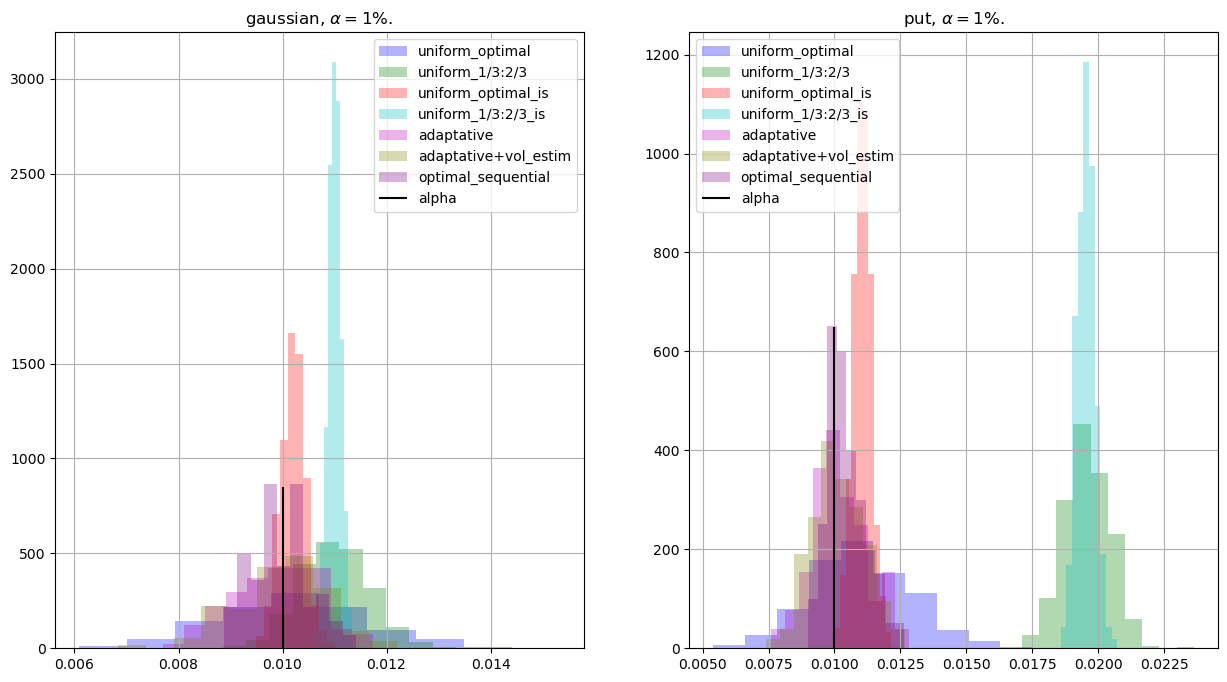

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'olive', 'purple']

for j, method_name in enumerate(methods_names):
    for i, pb in enumerate(problems):
        ax[i].hist(stats[pb][method_name], label=method_name, alpha=0.3, density=True, color=colors[j])
        ax[i].grid()
        ax[i].set_title(pb + r', $\alpha=1\%$.')

ax[0].vlines(0.01, 0, 850, 'k', label='alpha')
ax[1].vlines(0.01, 0, 650, 'k', label='alpha')
ax[0].legend()
ax[1].legend()
plt.show()

### Conclusions

- Statistics obtained for the case $\alpha = 1\%$ for both problems are consistent with the ones provided by the authors of the article.
- We see a very large bias that appears when using the uniform 1/3:2/3 method although its theoretical asymptotics is the same as for the optimal uniform algorithm. The error is even more dramatic for the put option example, possibly to the asymmetric and skewed loss distribution. We also note that optimal uniform algorithm demonstrates much more accurate results. This emphasizes the importance of the constant $\beta$ in the allocation which is, as we already mentioned, typically not available.
- The results above allow us to conclude that the adaptive method demonstrates a very good performance though it is not provided any information nor about optimal value of $n$, nor about the volatility $\sigma$.
- However, it should be mentioned that all the sequential methods (all apart from the uniform) are much more time-consuming since the losses are simulated one-by-one rather than as arrays. Even with git-compilation, the execution times for sequantial and non-sequential methods differ by orders of magnitude. In order to make them comparable, one should either implement the methods in C/C++ or use languages such as cython.
- Variance reduction techniques, in particular, importance sampling, allow us to decrease significantly the variance of the final estimator. However, it can not help to deal with the bias caused by a bad choice of $(n, m)$.
- Nevertheless, if comparing algorithms only in terms of budget, the simulation results provide strong evidence that sequential methods significantly outperform the uniform ones.